In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.pipeline import Pipeline
# importing classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/1stset/train_val.csv
/kaggle/input/1stset/test.csv
/kaggle/input/entropycompositionfulldataset/EntropyCompositionFullDataset.csv


In [2]:
# Assigning sets to variables
train_n_val = pd.read_csv("/kaggle/input/1stset/train_val.csv")
test = pd.read_csv("/kaggle/input/1stset/test.csv")

In [3]:
# Comparing shapes of both sets 
train_n_val.shape
print('Shape of training and validation set:', train_n_val.shape)
print('Shape of test set:', test.shape)

Shape of training and validation set: (29994, 6)
Shape of test set: (29994, 6)


# 1. Training of the model

In [4]:
train_n_val.head()

,NALLParticlesTotal,MUTotal,ELTOTAL,Zenith,Energy,Particle
0,-0.613555,-0.719462,-0.612942,-1.976304,-0.711469,1
1,-0.526344,-0.705012,-0.525643,0.983803,-0.659486,0
2,-0.021807,-0.603928,-0.020640,-0.592145,-0.329881,0
3,-0.589747,-0.635676,-0.589266,1.184899,-0.666990,3
4,-0.589553,-0.716015,-0.588915,0.713177,-0.692579,0


In [5]:
train_n_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29994 entries, 0 to 29993
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NALLParticlesTotal  29994 non-null  float64
 1   MUTotal             29994 non-null  float64
 2   ELTOTAL             29994 non-null  float64
 3   Zenith              29994 non-null  float64
 4   Energy              29994 non-null  float64
 5   Particle            29994 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.4 MB


In [6]:
train_n_val.describe()

,NALLParticlesTotal,MUTotal,ELTOTAL,Zenith,Energy,Particle
count,29994.000000,29994.000000,29994.000000,29994.000000,29994.000000,29994.000000
mean,0.002874,0.002086,0.002873,-0.003330,0.002531,2.000200
std,1.004406,1.002805,1.004409,0.999046,1.001264,1.414308
min,-0.615186,-0.721530,-0.614571,-3.437978,-0.712716,0.000000
25%,-0.583492,-0.666099,-0.583046,-0.606764,-0.669385,1.000000
50%,-0.436157,-0.450056,-0.436000,0.271573,-0.486482,2.000000
75%,0.149397,0.274302,0.148405,0.803861,0.275299,3.000000
max,5.756854,5.167450,5.763049,1.200399,3.469741,4.000000


In [7]:
# checking null values
train_n_val.isnull().sum()

NALLParticlesTotal    0
MUTotal               0
ELTOTAL               0
Zenith                0
Energy                0
Particle              0
dtype: int64

In [8]:
# Checking unique values in particle column
train_n_val['Particle'].unique() # 0 = photon, 1 = proton, 2 = helium, 3 = nitrogen, 4 = iron

array([1, 0, 3, 4, 2])

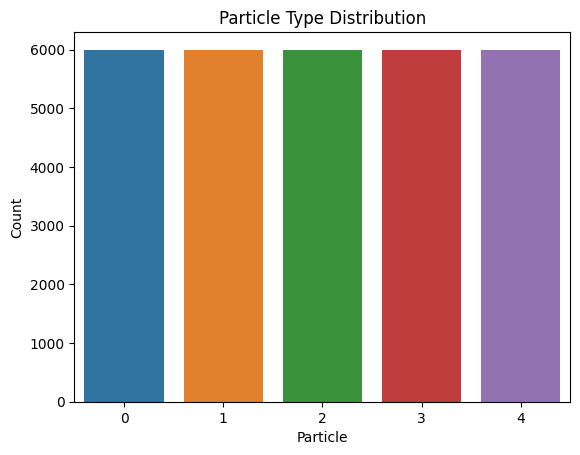

In [9]:
sns.countplot(x='Particle', data=train_n_val)
plt.title('Particle Type Distribution')
plt.xlabel('Particle')
plt.ylabel('Count')
plt.show()

In [10]:
# Checking whether particle feature is balanced or not
train_n_val['Particle'].value_counts()

Particle
0    6000
3    6000
4    6000
2    6000
1    5994
Name: count, dtype: int64

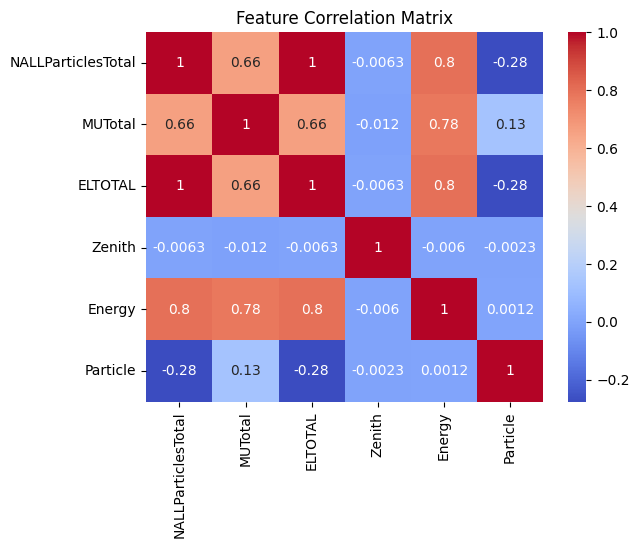

In [11]:
# plotting correlation
sns.heatmap(train_n_val.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [12]:
# Assigning dependent and independent features
x = train_n_val[["NALLParticlesTotal", "MUTotal", "ELTOTAL", "Zenith", "Energy"]] # or can write x = df.drop(column['Particle'])
y = train_n_val["Particle"]

In [13]:
# Split train_n_val into Train (80%) and Validation (20%)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [14]:
# Separate test features and labels
x_test = test.drop(columns=["Particle"])
y_test = test["Particle"]

### Scikit-learn offers tools for hyperparameter tuning which can help improve the performance of machine learning models like GridSearchCV and RandomizedSearchCV. 
### Hyperparameter tuning involves selecting the best set of parameters for a given model to maximize its efficiency and accuracy.

### In below code, paramters have defined as below,

### 1. n_estimators (Critical)
- Controls number of trees
- Higher values → better generalization but longer training
- range [50-500] is appropriate for initial search
### 2. max_depth (Very Important)
- Controls tree complexity
- None = unlimited growth
- range [10-30] helps prevent overfitting
### 3. min_samples_split (Important)
- Controls node splitting
### 4. min_samples_leaf
  - minimum samples required at leaf node
### 5. bootstrap
- choose whether to bootstrap sampling for building the trees or not

In [15]:
# defining grid of parameter
param_grid = {
    "n_estimators": [10, 20, 30, 100, 200, 300, 500, 1000],  # number of trees
    "max_depth": [10, 20, 30,50, None],  # depth of trees
    "min_samples_split": [2, 5, 10],  # minimum samples required to split
    "min_samples_leaf": [1, 2, 4],  # minimum samples per leaf
    "bootstrap": [True, False]  # bootstrap sampling
}

In [16]:
# creating instance for classifier and fitting
rf = RandomForestClassifier()

### Below block chooses the best parmeters defined in param_grid,
### 1. n_iter
- Number of iterations to try by combining the parameters and then evaluating the accuracy
### 2. cv
- cross vlidation splits the data in 5 parts/folds, model trained on 4 parts while validated on 1 part
### 3. verbose
- To see detailed output with progress
### 4. n_jobs
- used -1 to utilize all available processors to speeding the processing
### 5. scoring
- Used accuracy as performance matrix

In [17]:
# Run RandomizedSearchCV and train models on validation set
accuracies = []  # Store validation accuracy for each model
best_models = {}  # Store trained models

for i in range(1, 21):  
    print(f"\n🔄 Running RandomizedSearchCV iteration {i}/20...\n")
    
    # Perform Randomized Search
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=5,
        cv=5,
        verbose=1,
        n_jobs=-1,
        scoring="accuracy",
        random_state=i  # Different random state each time
    )
    
    # Fit model
    random_search.fit(x_train, y_train)
    
    # Store best parameters
    best_params = random_search.best_params_
    print(f"✅ best_params_{i}: {best_params}")

    # Train model with best parameters
    best_rf = RandomForestClassifier(**best_params, random_state=42)
    best_rf.fit(x_train, y_train)

    # Predict on validation set
    y_val_pred = best_rf.predict(x_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracies.append((f"Model_{i}", accuracy, best_rf))  # Store model as well

    print(f"✅ Validation Accuracy of Model_{i}: {accuracy:.4f}")


🔄 Running RandomizedSearchCV iteration 1/20...

Fitting 5 folds for each of 5 candidates, totalling 25 fits
✅ best_params_1: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': True}
✅ Validation Accuracy of Model_1: 0.9652

🔄 Running RandomizedSearchCV iteration 2/20...

Fitting 5 folds for each of 5 candidates, totalling 25 fits
✅ best_params_2: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}
✅ Validation Accuracy of Model_2: 0.9680

🔄 Running RandomizedSearchCV iteration 3/20...

Fitting 5 folds for each of 5 candidates, totalling 25 fits
✅ best_params_3: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
✅ Validation Accuracy of Model_3: 0.9688

🔄 Running RandomizedSearchCV iteration 4/20...

Fitting 5 folds for each of 5 candidates, totalling 25 fits
✅ best_params_4: {'n_estimators': 1000, 'min_samples_split': 2, 'min

In [18]:
# Find the best model based on validation accuracy
best_model_info = max(accuracies, key=lambda x: x[1])  # Get model with highest accuracy
best_model_name, best_val_accuracy, best_model = best_model_info

print(f"\n🏆 Best Model: {best_model_name} with Validation Accuracy: {best_val_accuracy:.4f}")


🏆 Best Model: Model_3 with Validation Accuracy: 0.9688


# 2. Now Predicting the data for test dataset

### Classification Report 

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Pipeline only for model prediction
best_model_pipeline = Pipeline([
    ('model', best_model)  # Only the best trained model
])

# Predict using the pipeline
y_val_pred = best_model_pipeline.predict(x_val)
y_test_pred = best_model_pipeline.predict(x_test)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Generate classification reports
val_classification = classification_report(y_val, y_val_pred)
test_classification = classification_report(y_test, y_test_pred)

# Print results
print(f"\n🏆 Best Model: {best_model_name} with Validation Accuracy: {val_accuracy:.4f}")
print(f"\n📌 Test Accuracy of Best Model ({best_model_name}): {test_accuracy:.4f}")

# Print classification reports with bold, centered headings
heading = "\033[1m🔍 Classification Report for Validation Set\033[0m"
print("\n" + heading.center(80, " ") + "\n")  
print(val_classification)

heading = "\033[1m🔍 Classification Report for Testing Set\033[0m"
print("\n" + heading.center(80, " ") + "\n")  
print(test_classification)



🏆 Best Model: Model_3 with Validation Accuracy: 0.9688

📌 Test Accuracy of Best Model (Model_3): 0.9664

               🔍 Classification Report for Validation Set               

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1200
           1       0.98      0.99      0.98      1199
           2       0.93      0.95      0.94      1200
           3       0.94      0.93      0.93      1200
           4       0.98      0.98      0.98      1200

    accuracy                           0.97      5999
   macro avg       0.97      0.97      0.97      5999
weighted avg       0.97      0.97      0.97      5999


                🔍 Classification Report for Testing Set                 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6000
           1       0.98      0.99      0.98      5994
           2       0.93      0.94      0.94      6000
           3       0.93      0.93      

### Below plotting confusion matrix both sets

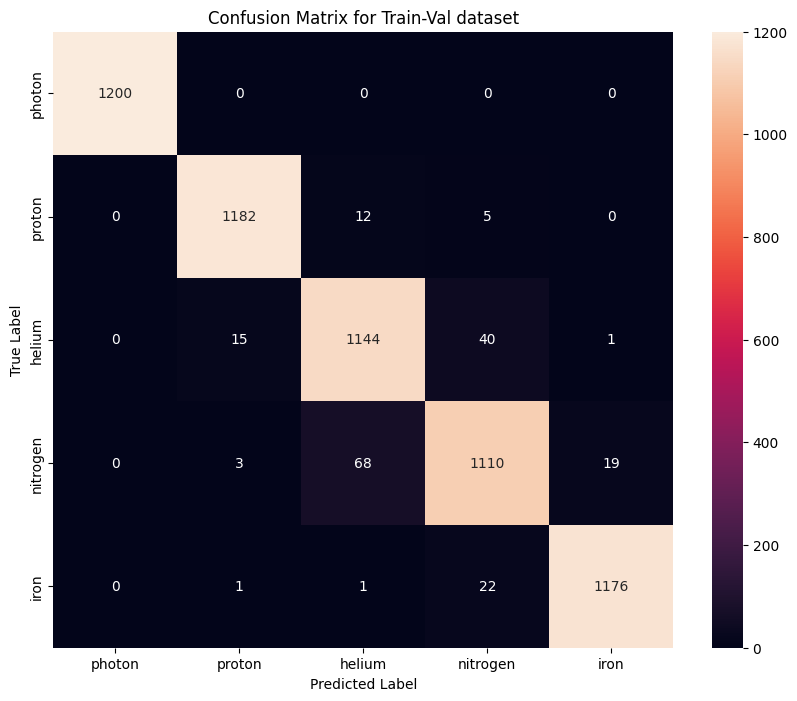

In [20]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['photon', 'proton', 'helium', 'nitrogen', 'iron'],
            yticklabels=['photon', 'proton', 'helium', 'nitrogen', 'iron'])
plt.title('Confusion Matrix for Train-Val dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

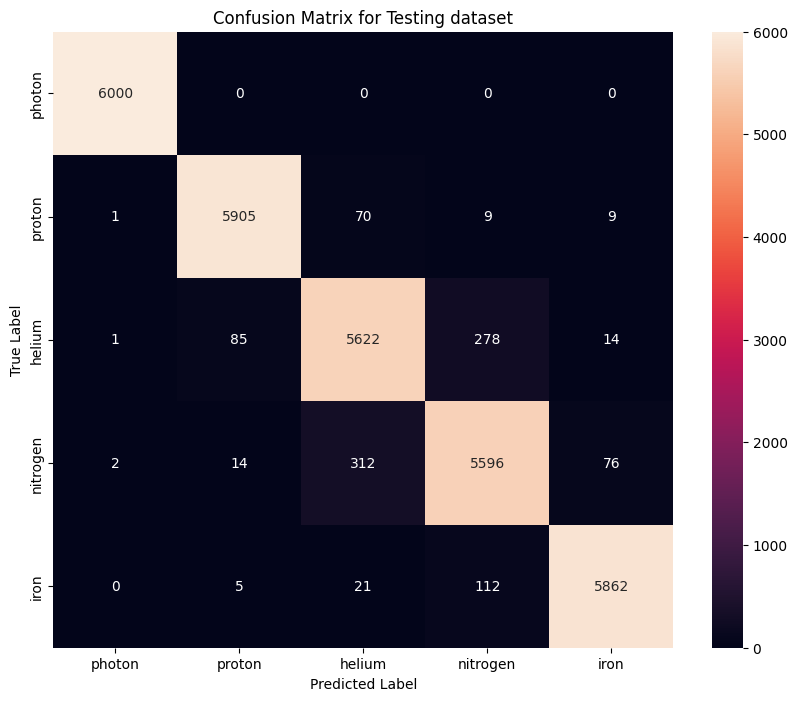

In [21]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['photon', 'proton', 'helium', 'nitrogen', 'iron'],
            yticklabels=['photon', 'proton', 'helium', 'nitrogen', 'iron'])
plt.title('Confusion Matrix for Testing dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()